In [402]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
X, y = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

/home/herring/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dat

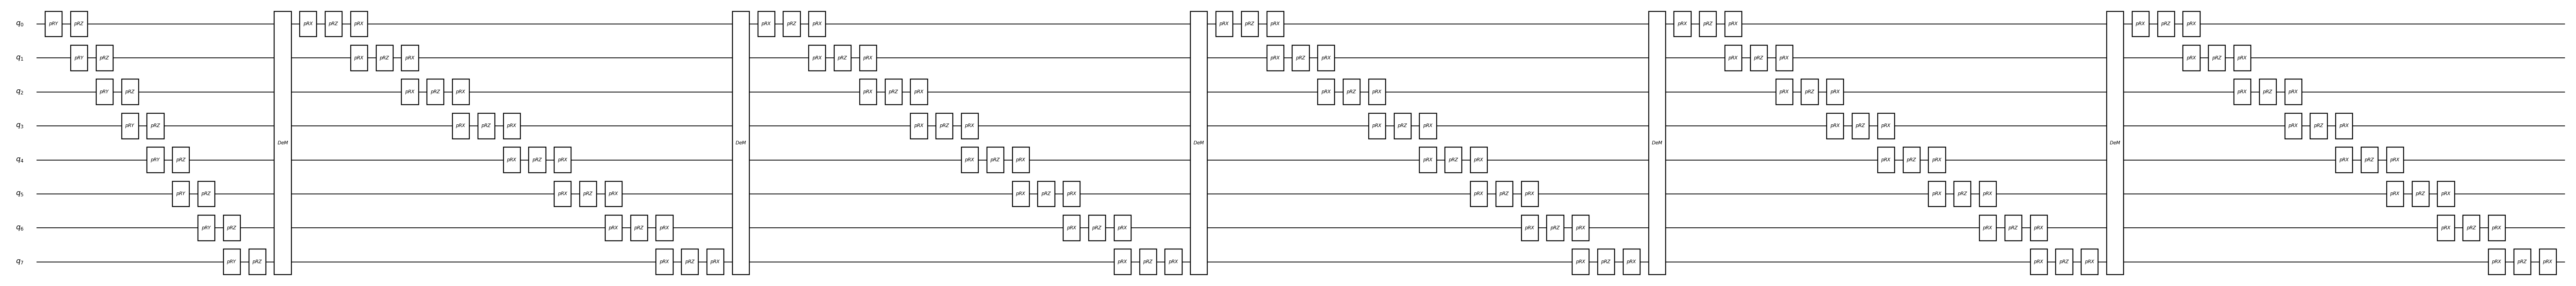

In [403]:
#ランダムな量子回路の作成
from skqulacs.circuit.pre_defined import create_qcl_ansatz
from qulacsvis import circuit_drawer
n_qubit = 8
def create_random_circuit():
    c_depth = 5
    circuit = create_qcl_ansatz(n_qubit,c_depth)
    return circuit

#qulacs-visualizerを試した
circuit = create_random_circuit()
circuit_drawer(circuit._circuit,"mpl")

In [404]:
#ランダムなオペレーターを持つオブザーバブルを作成
from qulacs import Observable
import random
def create_observable_list():
    observable_list = list()
    for _ in range(80):
        observable = Observable(n_qubit)
        observable.add_random_operator(random.randint(2,10))
        observable_list.append(observable)
    return observable_list

In [405]:
# 観測結果を得る
from qulacs import QuantumState
from qulacs.gate import RX,RY,RZ
import numpy as np

def get_observation_result_list(X_scaled,circuit,observable_list):
    observation_result_list = list()

    for x in X_scaled:
        # 量子状態を作成
        state = QuantumState(n_qubit)
        state.set_zero_state()
        for i in range(len(x)):
            if (i // n_qubit) % 2 == 0:
                RX(i%n_qubit,x[i]*np.pi).update_quantum_state(state)
            else:
                RZ(i%n_qubit,x[i]*np.pi).update_quantum_state(state)

        # 量子回路を作用させる
        circuit._circuit.update_quantum_state(state)
        
        # 観測し、その結果をリストに追加する
        observation_result_list.append([observable.get_expectation_value(state) for observable in observable_list])

    return observation_result_list

In [406]:
from sklearn.preprocessing import MinMaxScaler

def do_scale(X_train,X_test):
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled,X_test_scaled

In [407]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
linear_regression = LinearRegression()

X_train_scaled, X_test_scaled = do_scale(X_train,X_test)
circuit = create_random_circuit()
observable_list = create_observable_list()

observation_result_list = get_observation_result_list(X_train_scaled,circuit,observable_list)
linear_regression.fit(observation_result_list,y_train)
print("訓練データのスコア",linear_regression.score(observation_result_list,y_train))

observation_result_list = get_observation_result_list(X_test_scaled,circuit,observable_list)
print("テストデータのスコア",linear_regression.score(observation_result_list,y_test))

訓練データのスコア 0.8958543503646847
テストデータのスコア 0.7312564151202043


In [408]:
#ただの重回帰分析（比較用）
linear_regression.fit(X_train,y_train)
print("訓練データのスコア",linear_regression.score(X_train,y_train))
print("テストデータのスコア",linear_regression.score(X_test,y_test))

訓練データのスコア 0.7631050720165627
テストデータのスコア 0.6421247309663016
